# Imports

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import polars as pl
pl.enable_string_cache()

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import yaml

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
import lightgbm as lgb

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

import optuna
import time

# root path
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path
if ROOT not in sys.path:
    sys.path.append(ROOT)

# Import helper functions
from src.data_preprocessing.cleaner import PolarsLoader
from src.data_preprocessing.feature_engineering import FeatureEngineering

In [2]:
DATA_PATH = os.path.join(ROOT, "data")

TRAIN_FILE = os.path.join(DATA_PATH, "train_data.csv")
TEST_FILE = os.path.join(DATA_PATH, "test_data.csv") 

# Data Loading

In [3]:
NEG_RATIO = 5

# Total amount of positive samples
# 802_061

# Total amount of negative samples
# 8_020_610

# Initial negative ratio
# 10

In [4]:
pp = PolarsLoader(sampling=True)
pl_train, CAT_COLS, NUM_COLS = pp.initial_preprocessing(TRAIN_FILE, is_train=True, neg_ratio=NEG_RATIO)
pl_test, _, _ = pp.initial_preprocessing(TEST_FILE, is_train=False)

FEATURES = CAT_COLS + NUM_COLS
TARGET = 'target'

#Print data information
print(f"Train data shape: {pl_train.shape}")
print(f"Test data shape: {pl_test.shape}")
print("-"*50)

print(f"Number of categorical columns: {len(CAT_COLS)}")
print(f"Number of numerical columns: {len(NUM_COLS)}")
print("-"*50)

print(f"% target distribution in train data after downsampling:\n {pl_train['target'].value_counts(normalize=True)}")

Train data shape: (170274, 18)
Test data shape: (1000000, 18)
--------------------------------------------------
Number of categorical columns: 10
Number of numerical columns: 7
--------------------------------------------------
% target distribution in train data after downsampling:
 shape: (2, 2)
┌────────┬────────────┐
│ target ┆ proportion │
│ ---    ┆ ---        │
│ i16    ┆ f64        │
╞════════╪════════════╡
│ 0      ┆ 0.833333   │
│ 1      ┆ 0.166667   │
└────────┴────────────┘


# Feature Engineering

In [5]:
fe = FeatureEngineering()

train, NEW_COLS = fe.proccess(pl_train, CAT_COLS, is_train=True)
test, _ = fe.proccess(pl_test, CAT_COLS, is_train=False)

FEATURES += NEW_COLS

## Testing over sampling

In [55]:
# # Create a pipeline with only the oversampler
# UP_RATIO = (NEG_RATIO/100) + 0.1

# RO = RandomOverSampler(sampling_strategy=UP_RATIO)

# X = train[FEATURES]
# y = train[TARGET]

# # Apply the oversampling to your data
# X_resampled, y_resampled = RO.fit_resample(X, y)

# # Check the final shape of the resampled data
# print(f"Initial X shape: {X.shape}")
# print(f"Resampled X shape: {X_resampled.shape}")

# # Check the target count before and after resampling
# target_before = Counter(y)
# print(f"Target distribution before oversampling: {target_before}")

# target_after = Counter(y_resampled)
# print(f"Target distribution after oversampling: {target_after}")

# Model training

# Crossvalidation

In [15]:
lgb_params = {
    'objective': 'binary',
    'metric': 'f1',
    'verbose': -1,
    'random_state': 23,
    'boosting_type':  'gbdt',
    'n_estimators': 200,
}

In [16]:
multiplier = 1.5

UP_RATIO = round((NEG_RATIO/100) * multiplier, 5)
print(f"UP_RATIO: {UP_RATIO}")

estimator = Pipeline([
    # ('over_sampler', RandomOverSampler(sampling_strategy=UP_RATIO)),     
    ('classifier', lgb.LGBMClassifier(**lgb_params)),
])

UP_RATIO: 0.075


In [17]:
X = train[FEATURES]
y = train[TARGET]

cv = KFold(5, shuffle=True, random_state=23)

results = cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=cv,
    scoring='f1',
    return_train_score=True
)

# Print F1 scores for both train and validation
print(f"Folds Train F1 scores: {results['train_score']}")
print(f"Folds Validation F1 scores: {results['test_score']}")

# Print mean F1 scores
print("*"*50)
print(f"Mean Train F1 score: {np.mean(results['train_score'])}")
print(f"Mean Validation F1 score: {np.mean(results['test_score'])}")


### CV Scores with train 1M sample ###

# Initial
#0.470

# Undersampling netg_ratio 10
#0.620

# With randomoversampler
#0.645 --> 0.2
#0.640 --> 0.15
#0.638 --> 0.3

### CV Scores with FULL TRAIN ###

# Undersampling netg_ratio 5 - no oversampling
# Mean Train F1 score: 0.7209108508146046
# Mean Validation F1 score: 0.7185630002589082

Folds Train F1 scores: [0.72065583 0.72083091 0.72090365 0.72116506 0.72099881]
Folds Validation F1 scores: [0.71829718 0.71952835 0.7192114  0.71812244 0.71765562]
**************************************************
Mean Train F1 score: 0.7209108508146046
Mean Validation F1 score: 0.7185630002589082


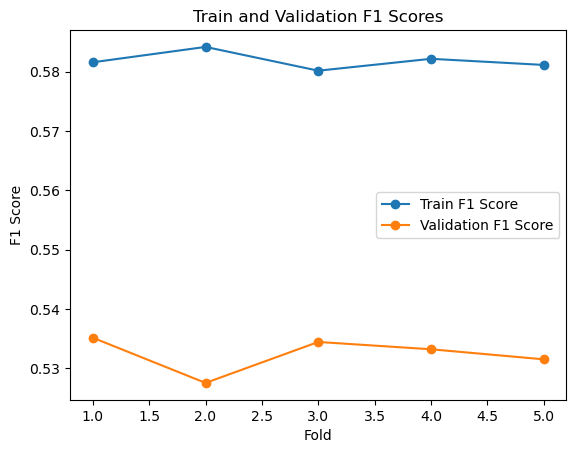

In [59]:
# Get train and validation F1 scores
train_scores = results['train_score']
valid_scores = results['test_score']

# Plot
plt.plot(range(1, len(train_scores) + 1), train_scores, marker='o', label='Train F1 Score', linestyle='-')
plt.plot(range(1, len(valid_scores) + 1), valid_scores, marker='o', label='Validation F1 Score', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Train and Validation F1 Scores')
plt.legend()
plt.show()

# Train and predict

In [18]:
BENCHMARK = 0.503

estimator.fit(X, y)

predictions = estimator.predict(test[FEATURES])
test_f1 = f1_score(test[TARGET], predictions)

print(f"F1 on test data: {round(test_f1, 3)}")
print(f"Improvement over Benchmark: {round(100*((test_f1/BENCHMARK)-1),2)}%")


### FULL TRAIN ###

# Undersampling netg_ratio 5 - no oversampling

# F1 on test data: 0.619
# Improvement over Benchmark: 23.02%

F1 on test data: 0.619
Improvement over Benchmark: 23.02%


# Feature importance

In [19]:
CHECK_FI = True

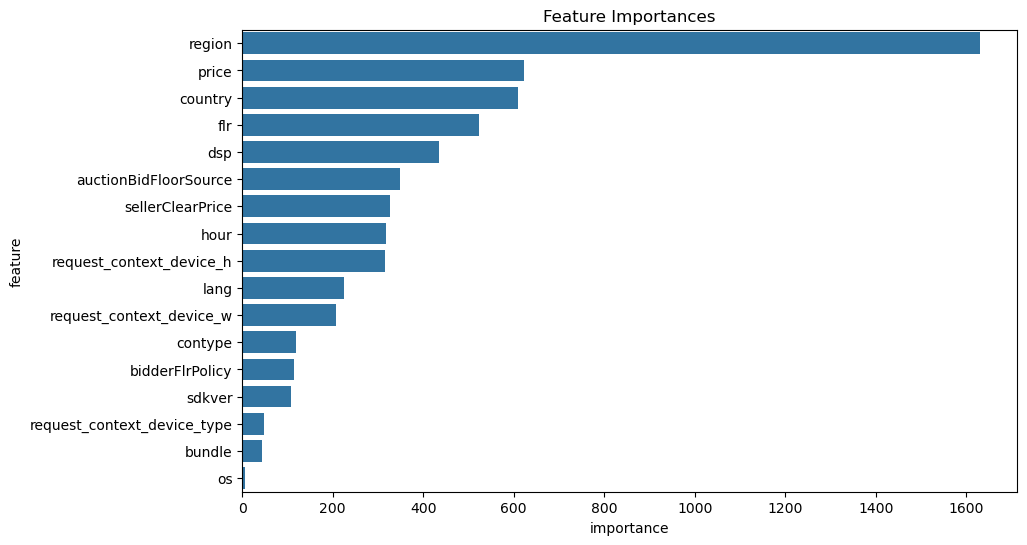

In [20]:
if CHECK_FI:

    #Create feature importances dataframe
    importances = estimator.named_steps['classifier'].feature_importances_
    importances_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    #Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importances_df)
    plt.title('Feature Importances')
    plt.show()

# Hyperparameter tunning

In [27]:
DO_TUNING = True

In [30]:
def lgb_objective(trial):
        
    try:
        # params = {
        #     'objective': 'binary',
        #     'metric': 'f1',
        #     'verbose': -1,
        #     'random_state': 23,
        #     'boosting_type':  'gbdt',
        #     'n_estimators': 200,
        #     'lambda_l2':         trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),
        #     'learning_rate':     trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        #     'max_depth':         trial.suggest_int('max_depth', 4, 8),
        #     'num_leaves':        trial.suggest_int('num_leaves', 16, 256),
        #     'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 0.8, 4.0),
        # }

        params = {
            'objective': 'binary',
            'metric': 'f1',
            'verbose': -1,
            'random_state': 23,
            'boosting_type': 'gbdt',
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'min_child_samples': trial.suggest_int('min_child_samples', 100, 500),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.8, 4.0),
        }

        # multiplier = trial.suggest_float('up_ratio_multiplier', 1.1, 256),
        # UP_RATIO = (NEG_RATIO/100) * multiplier

        estimator = Pipeline([
            # ('over_sampler', RandomOverSampler(sampling_strategy=UP_RATIO)),     
            ('classifier', lgb.LGBMClassifier(**params)),
        ])

        X = train[FEATURES]
        y = train[TARGET]

        estimator.fit(X, y)

        predictions = estimator.predict(test[FEATURES])
        test_f1 = f1_score(test[TARGET], predictions)

        return test_f1

    except ValueError as e:
            # Handle known sampling issues
            print(f"Skipping trial due to error: {e}")
            return None  # Optuna will automatically skip this trial

In [29]:
if DO_TUNING:
    
    start_time = time.time()
    study_lgb = optuna.create_study(direction='maximize')
    study_lgb.optimize(lgb_objective, n_trials=50)
    end_time = time.time()
    elapsed_time_lgb = end_time - start_time
    print(f"LightGBM tuning took {elapsed_time_lgb:.2f} seconds.")
    print("Best LGBM trial:", study_lgb.best_trial)

[I 2024-10-18 12:21:09,970] A new study created in memory with name: no-name-34cccce6-1d2c-4882-9912-c885f1e0485a
[I 2024-10-18 12:24:46,379] Trial 0 finished with value: 0.5443890886828628 and parameters: {'n_estimators': 962, 'learning_rate': 0.01608722855535212, 'max_depth': 6, 'min_child_samples': 256, 'scale_pos_weight': 3.1349001410922037}. Best is trial 0 with value: 0.5443890886828628.
[I 2024-10-18 12:25:43,726] Trial 1 finished with value: 0.5688026633550021 and parameters: {'n_estimators': 367, 'learning_rate': 0.0984158752656917, 'max_depth': 3, 'min_child_samples': 386, 'scale_pos_weight': 2.0854611661914015}. Best is trial 1 with value: 0.5688026633550021.
[I 2024-10-18 12:27:43,742] Trial 2 finished with value: 0.5771803004338096 and parameters: {'n_estimators': 542, 'learning_rate': 0.0182423975875758, 'max_depth': 5, 'min_child_samples': 400, 'scale_pos_weight': 1.7499033862106388}. Best is trial 2 with value: 0.5771803004338096.
[I 2024-10-18 12:29:30,636] Trial 3 fin